In [1]:
import glob, sys
import numpy as np
import matplotlib.pyplot as plt
import time
import pyccl as ccl
cosmo = ccl.Cosmology(Omega_c = 0.30711 - 0.048254, Omega_b = 0.048254, h = 0.677, sigma8 = 0.8288, n_s=0.96)

In [2]:
%load_ext autoreload
%autoreload 2
import CL_COUNT_class_cluster_abundance as cl_count

initialize the `ClusterAbundance` object

In [3]:
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncTinker08(cosmo, mass_def=massdef)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25)*4*np.pi

# Binned approach
Compute the 2D integral

$$
N_{\alpha\beta}^{\rm predicted} = \Omega_s\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\log_{10}M_\beta}^{\log_{10}M_{\beta + 1}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}d\log_{10}M
$$

define mass & redshift binning

In [7]:
z_edges = np.linspace(0.25, 1.25, 16)
logm_edges = np.linspace(14, 14.8, 11)
# def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
# Z_bin = binning(z_corner)
# logMass_bin = binning(logm_corner)

Three different methods:
1. Simpson integration of a tabulated grid of $\Omega\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}$ (method `grid`)
2. Double integral using `scipy.integrate.dblquad` over a interpolated function based on a tabulated grid of $\Omega\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}$ (method `interp`)
3. Double integral using `scipy.integrate.dblquad` of $\Omega\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}$ (method `exact`)

In [37]:
#define redshift-mass grid
z_grid = np.linspace(0., 3, 500)
logm_grid = np.linspace(12,16, 500)

`grid`

In [38]:
t0 = time.time()
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance_grid = clc.Cluster_Abundance_MZ(zbin_edges = z_edges, proxybin_edges = logm_edges, method = 'grid')
t1 = time.time()
print('time (seconds) = ' + str(t1-t0))
time_simps = t1-t0

time (seconds) = 0.519888162612915


`interp`

In [14]:
t0 = time.time()
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance_interp = clc.Cluster_Abundance_MZ(zbin_edges = z_edges, proxybin_edges = logm_edges, method = 'interp')
t1 = time.time()
print('time (seconds) = ' + str(t1-t0))
time_dblquad_interp = t1-t0

time (seconds) = 2.9997479915618896


`exact`

In [15]:
t0 = time.time()
Abundance_exact = clc.Cluster_Abundance_MZ(zbin_edges = z_edges, proxybin_edges = logm_edges, method = 'exact')
t1 = time.time()
print('time (seconds) = ' + str(t1-t0))
time_exact_CCL = t1-t0

time (seconds) = 37.46456718444824


We plot the biais of the 2 first methods relative to the `exact` method

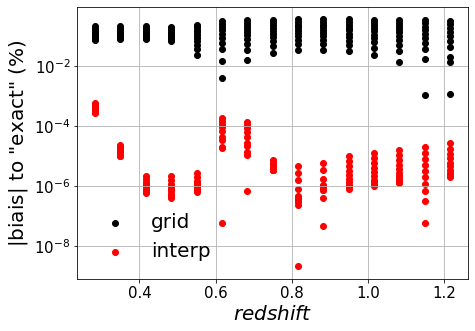

In [39]:
plt.figure(figsize = (7,5))
plt.yscale('log')
z_ = [np.mean([z_edges[i],z_edges[i+1]]) for i in np.arange(len(z_edges)-1)]
mass = [np.mean([10**logm_edges[i],10**logm_edges[i+1]]) for i in np.arange(len(logm_edges)-1)]
plt.tick_params(axis='both', which="both", labelsize= 15)
for f in range(len(logm_edges)-1):
    label = [None, None]
    if f == 0:
        label = ['grid', 'interp']
    y_grid = abs(100*(1-Abundance_grid[:,f]/Abundance_exact[:,f]))
    y_interp = abs(100*(1-Abundance_interp[:,f]/Abundance_exact[:,f]))
    plt.scatter(z_, y_grid, color = 'k', label = label[0])
    plt.scatter(z_, y_interp, color = 'r', label = label[1])
plt.grid(True, which="both" )
plt.ylabel(r'|biais| to "exact" $(\%)$', fontsize = 20)
plt.xlabel(r'$redshift$', fontsize = 20)
plt.legend(frameon = False, fontsize = 20)
plt.show()

In [33]:
halobais_model = ccl.halos.hbias.HaloBiasTinker10(cosmo, mass_def=massdef, mass_def_strict=True)

In [34]:
clc.compute_halo_bias_grid_MZ(z_grid = z_grid, logm_grid = logm_grid, halobiais = halobais_model)

In [35]:
biais_grid = clc.halo_bias_MZ(zbin_edges = z_edges, proxybin_edges = logm_edges, N_th = Abundance_grid, method ='grid')

In [36]:
biais_exact = clc.halo_bias_MZ(zbin_edges = z_edges, proxybin_edges = logm_edges, N_th = Abundance_exact, method ='exact')

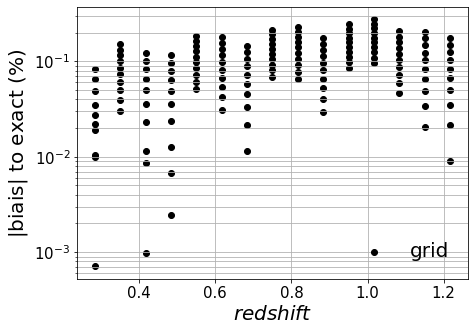

In [44]:
plt.figure(figsize = (7,5))
plt.yscale('log')
z_ = [np.mean([z_edges[i],z_edges[i+1]]) for i in np.arange(len(z_edges)-1)]
mass = [np.mean([10**logm_edges[i],10**logm_edges[i+1]]) for i in np.arange(len(logm_edges)-1)]
plt.tick_params(axis='both', which="both", labelsize= 15)
for f in range(len(logm_edges)-1):
    label = [None, None]
    if f == 0:
        label = ['grid', 'interp']
    y_simps = abs(100*(1-biais_grid[:,f]/biais_exact[:,f]))
    plt.scatter(z_, y_simps, color = 'k', label = label[0])
plt.grid(True, which="both" )
plt.ylabel(r'|biais| to exact $(\%)$', fontsize = 20)
plt.xlabel(r'$redshift$', fontsize = 20)
plt.legend(frameon = False, fontsize = 20)
plt.show()

# Un-binned approach

Compute $$\frac{d^2V(z_i)}{dz d\Omega}\frac{dn(M_i,z_i)}{d\log_{10}M_i}$$ for each masses and redshifts in a dark matter halo catalog

In [45]:
#Generate mass, redshift catalog
n_cluster = 100000
redshift, M200c = np.random.random(n_cluster)*(1 - 0.2) + 0.2, 10**(np.random.random(n_cluster)*(15 - 13) + 13)

Method :
1. compute individual $\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}$ from an interpolated function over a tabulated grid
2. use CCL prediction for each dark matter halo mass ad redshift

In [46]:
t0 = time.time()
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
multiplicity_interp = clc.multiplicity_function_individual_MZ(z = redshift, logm = np.log10(M200c), method = 'interp')
t1 = time.time()
print('time (seconds) = ' + str(t1-t0))

time (seconds) = 0.6472704410552979


In [50]:
t0 = time.time()
multiplicity_exact = clc.multiplicity_function_individual_MZ(z = redshift, logm = np.log10(M200c), method = 'exact')
t1 = time.time()
print('time (seconds) = ' + str(t1-t0))

time (seconds) = 22.555680990219116


Text(0, 0.5, '|biais| to CCL $(\\%)$')

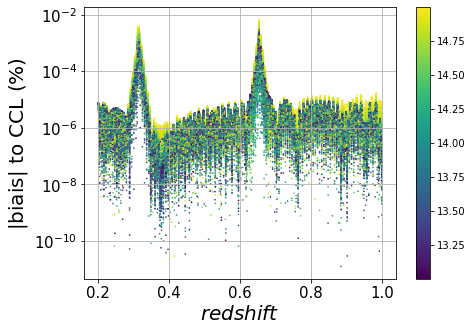

In [51]:
plt.figure(figsize = (7,5))
plt.yscale('log')
plt.tick_params(axis='both', which = 'major', labelsize= 15)
plt.scatter(redshift, abs(100*(1-multiplicity_interp/np.array(multiplicity_exact))), s = 0.4, c = np.log10(M200c))
plt.colorbar()
plt.grid(True, which='both')
plt.xlabel(r'$redshift$', fontsize = 20)
plt.ylabel(r'|biais| to CCL $(\%)$', fontsize = 20)